## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images. (O)
* Apply a distortion correction to raw images. (O)
* Use color transforms, gradients, etc., to create a thresholded binary image.(O)
* Apply a perspective transform to rectify binary image ("birds-eye view"). (O)
* Detect lane pixels and fit to find the lane boundary.(O)
* Determine the curvature of the lane and vehicle position with respect to center.(O)
* Warp the detected lane boundaries back onto the original image. (O)
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.(O)

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from util import *
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
# Calibrate the camera
# Use tge cv2 calibrateCamera function to get the convert(3D to 2D)
# matrix and distance r
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,gray.shape[::-1], None, None)
# twos arrays for warpping
src = np.float32([[585,461],
                  [200,717],
                  [1088,704],
                  [708,459]])
dst = np.float32([[320,0],
                  [320,720],
                  [980,720],
                  [980,0]])
# Camera Matrix for both forward and inverse
M = cv2.getPerspectiveTransform(src,dst)
invM = cv2.getPerspectiveTransform(dst,src)

## Second, apply a distortion correction to one raw image.

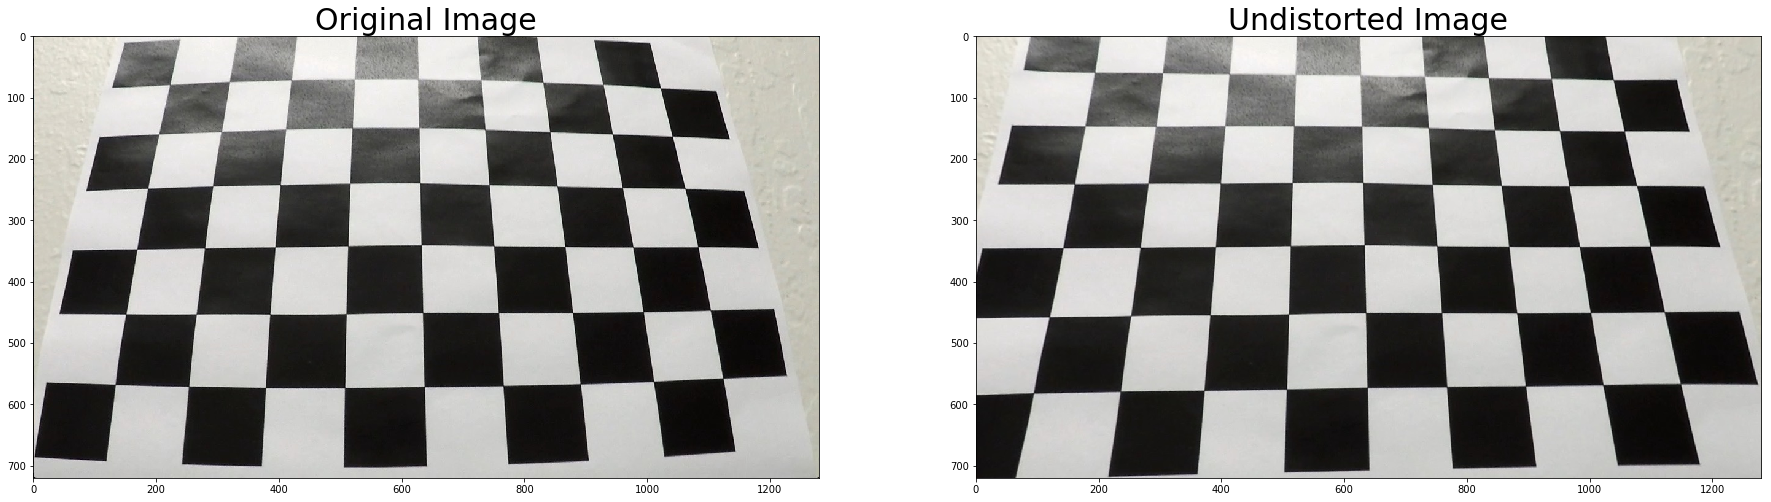

In [2]:
img = cv2.imread(images[4])
# Convert the image from BGR to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Undistort the image
undistorted = cal_undistort(img, mtx, dist)
# Plot the original and undistored images then save it
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistort_output.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

## Try the binary threshold on one undistorted image

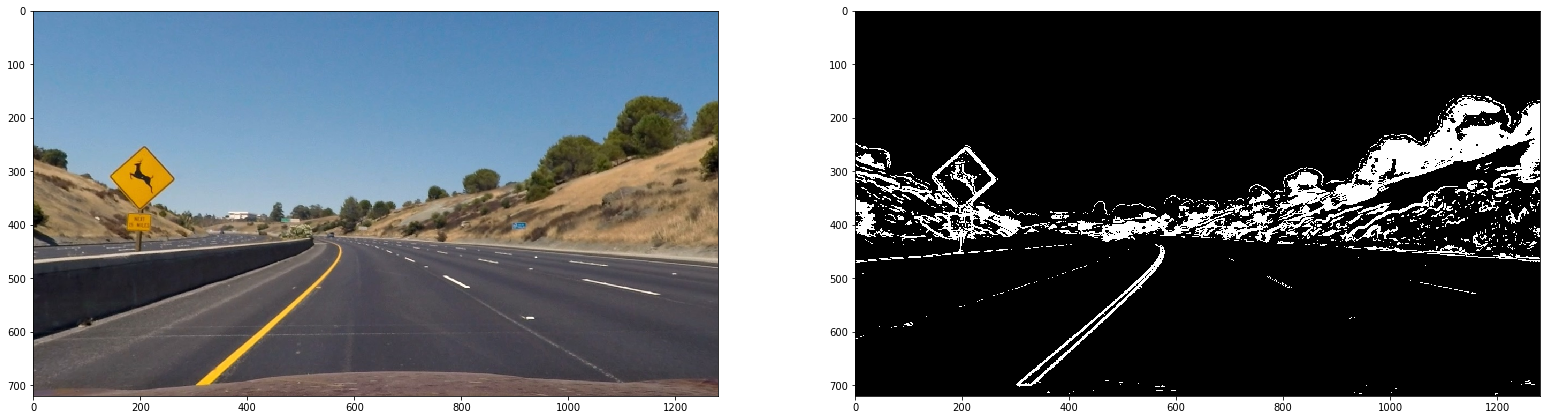

In [3]:
test_image = cv2.imread('test_images/test2.jpg')
# Convert the image to RGB
test_image = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
# Undistort the image
undist_test_image = cal_undistort(test_image,mtx, dist)
# Get the offset
gray = cv2.cvtColor(undist_test_image,cv2.COLOR_RGB2GRAY)
histogram = np.sum(gray[gray.shape[0]//2:,:], axis=0)
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
center = (leftx_base+rightx_base)/2
offset = abs(center-gray.shape[1])*3.7/abs(rightx_base - leftx_base)
offset = round(offset, 2)
# Set the threshold and kernel size for binary output
kernel_size = 9
dir_thres = (0.7,1.3)
mag_thres = (30,200)
hls_thres = (40,240)
luv_thres = (225,255)
hsv_thres = (18,30)
# Apply the magnitude, HLS and directional threshold
combined_binary = combined_select(undist_test_image, kernel_size, mag_thres, hls_thres, luv_thres,hsv_thres)
# combined_binary = combined_select(undist_test_image, kernel_size)
# plot the output
f,(ax1,ax2) = plt.subplots(1,2,figsize =(27,72))
ax1.imshow(undist_test_image)
ax2.imshow(combined_binary,cmap = 'gray')

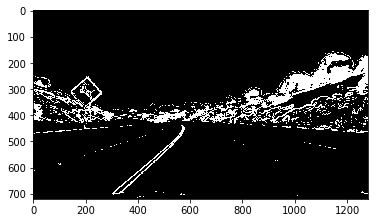

In [4]:
plt.imshow(combined_binary,cmap = 'gray')
plt.savefig('output_images/binary_combo.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

## Warp the image to get the bird-view scene

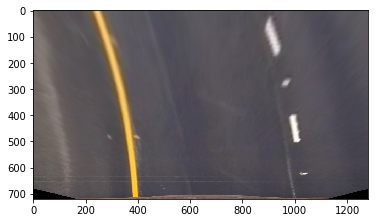

In [5]:
# Warp the image, plot it and save it
warpped_img = warp(undist_test_image, M)
plt.imshow(warpped_img)
plt.savefig('output_images/bird_view.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

## Warp the binary image and get the lane boundary

In [6]:
# Apply it to the warpped image and the test_image
warpped_binary = combined_select(warpped_img,kernel_size, mag_thres,hls_thres,luv_thres,hsv_thres)

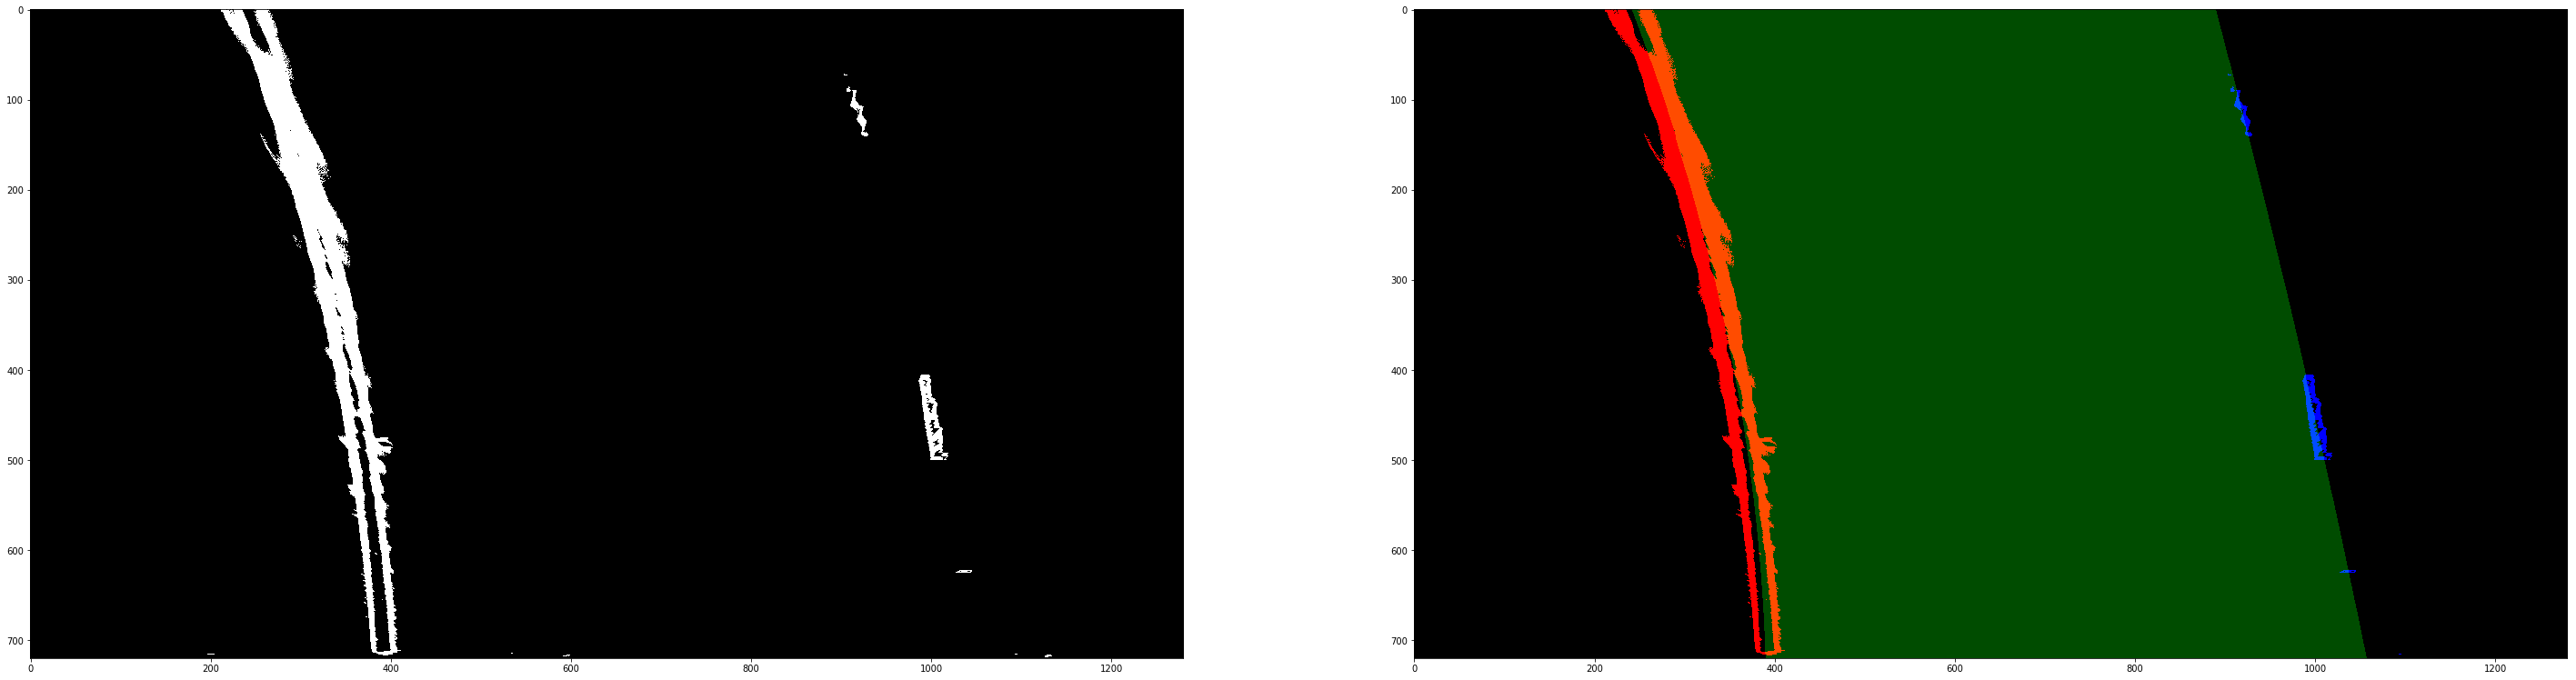

In [7]:
# Get the curve image and the radius of the curve
result,rad = fit_polynomial(warpped_binary)
# Plot the warpped images, test_image and the result
f, (ax1,ax2) = plt.subplots(1,2,figsize= (50,150))
ax1.imshow(warpped_binary,cmap = 'gray')
ax2.imshow(result,cmap = 'gray')
plt.savefig('output_images/curve_image.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

## Unwarp the image

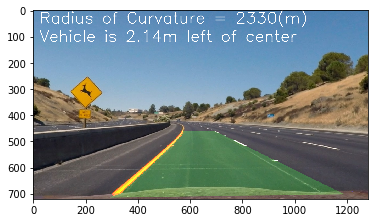

In [8]:
# Unwarp the image
unwarpped_img = unwarp(result,invM)
# Add the umwarp result to the original image
final = cv2.addWeighted(undist_test_image, 1, unwarpped_img, 0.7, 0)
cv2.putText(final, "Radius of Curvature = "+str(rad)+"(m)",(25, 50), cv2.FONT_HERSHEY_SIMPLEX,
                2.0, (255, 255, 255),2, lineType=cv2.LINE_AA) 
cv2.putText(final, "Vehicle is "+str(offset)+"m left of center",(25, 120), cv2.FONT_HERSHEY_SIMPLEX,
                2.0, (255, 255, 255),2, lineType=cv2.LINE_AA)
# plot the final rusult
plt.imshow(final)
plt.savefig('output_images/final.png', dpi=None, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

In [9]:
def process_image(img):
    undist_image = cal_undistort(img,mtx,dist)
    gray = cv2.cvtColor(undist_image,cv2.COLOR_RGB2GRAY)
    histogram = np.sum(gray[gray.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    center = (leftx_base+rightx_base)/2
    offset = abs(center-gray.shape[1]/2)*3.7/abs(rightx_base - leftx_base)
    offset = round(offset, 2)
    warpped_img = warp(undist_image,M)
    kernel_size = 9
    dir_thres = (0.7,1.3)
    mag_thres = (30,200)
    hls_thres = (40,240)
    luv_thres = (225,255)
    hsv_thres = (18,30)
    combined_binary = combined_select(warpped_img, kernel_size, mag_thres, hls_thres,hsv_thres,hsv_thres)
    result,rad = fit_polynomial(combined_binary)
    unwarpped_img = unwarp(result,invM)
    final = cv2.addWeighted(undist_image, 1, unwarpped_img, 0.7, 0)
    cv2.putText(final, "Radius of Curvature = "+str(rad),(25, 50), cv2.FONT_HERSHEY_SIMPLEX,
                2.0, (255, 255, 255),2, lineType=cv2.LINE_AA)
    cv2.putText(final, "Vehicle is "+str(offset)+"m left of center",(25, 120), cv2.FONT_HERSHEY_SIMPLEX,
                2.0, (255, 255, 255),2, lineType=cv2.LINE_AA)
    return final

In [10]:
from moviepy.editor import VideoFileClip

In [11]:
white_output = 'output_images/test_output.mp4'
# clip1 = VideoFileClip("project_video.mp4").subclip(30,43)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/test_output.mp4
[MoviePy] Writing video output_images/test_output.mp4


100%|█████████▉| 1260/1261 [03:33<00:00,  5.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_output.mp4 

CPU times: user 9min 59s, sys: 2min 11s, total: 12min 10s
Wall time: 3min 34s
